In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Dropout, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [2]:
Y_train = np.load('Y_train.npy')
X_train = np.load('X_train.npy')
Y_test = np.load('Y_test.npy')
X_test = np.load('X_test.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'Y_train.npy'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
Y_train.shape

(32, 32, 12548)

In [ ]:
X_train.shape

(32, 32, 12, 12548)

In [ ]:
m = X_train.shape[0]
m_test = X_test.shape[0]
n_h = X_train.shape[1]
n_w = X_train.shape[2]
n_features = X_train.shape[3]

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def res_block_maxpool(X,stage,s=1,filters=16):
    
    # name defining basis as used in ResNet assignment
    conv_name_base = 'conv' + str(stage) +  '_branch'
    pool_name_base = 'pool' + str(stage) +  '_branch'
    
    # Input value for shortcut layer
    X_shortcut = X
    
    
    # Main Path
    # Component 1 of main path
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 2 of main path
    X = MaxPooling2D(pool_size = (2,2), padding='same', strides = (1,1), name = pool_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 3 of main path
    X = Conv2D(filters, kernel_size=(3,3), padding='same', strides = (1,1), name = conv_name_base + '2a')(X)
    X = Dropout(0.1)(X)
    
    # Shortcut Path
    X_shortcut = Conv2D(filters, kernel_size=(3,3), padding='same', strides = (1,1), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = Dropout(0.1)(X_shortcut)
    
    # Adding main path and activation
    X = Add()([X, X_shortcut])
    
    return X
    

In [ ]:
def res_block_conv(X,stage,s=1,filters=32):
    
    # name defining basis as used in ResNet assignment
    conv_name_base = 'conv' + str(stage) + '_branch'
    pool_name_base = 'pool' + str(stage) + '_branch'
    
    # Input value for shortcut layer
    X_shortcut = X
    
    
    # Main Path
    # Component 1 of main path
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 2 of main path
    X = Conv2D(filters, kernel_size = (2,2), padding='same', strides = (s,s), name = pool_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    
    # Component 3 of main path
    X = Conv2D(filters, kernel_size=(3,3), padding='same', strides = (s,s), name = conv_name_base + '2a')(X)
    X = Dropout(0.1)(X)
    
    # Shortcut Path
    X_shortcut = Conv2D(filters, kernel_size=(3,3),  padding='same', strides = (s,s), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = Dropout(0.1)(X_shortcut)
    
    # Adding main path and activation
    X = Add()([X, X_shortcut])
    
    return X

In [ ]:
def ResNet(input_shape = (32,32,12), classes=2, filters =16):
    
    # Input tensor
    X_input = Input(input_shape)
    
    X = X_input
    
    
    # Stage 1
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.1)(X)
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1))(X)
    
    # Stage 2
    X = res_block_maxpool(X, stage=2, filters=16, s=1)
    
    # Stage 3
    X = res_block_maxpool(X, stage=3, filters=16, s=1)
    
    #Stage 4
    X = res_block_conv(X, stage=4, filters=32, s=1)
    
    # Stage 5
    X = res_block_conv(X, stage=5, filters=32, s=1)
    
    # Stage 6
    X = Conv2D(filters, kernel_size=(3,3),padding='same', strides=(1,1), name='conv6')(X)
    X = Activation('relu')(X)
    
    # Averagepool
    X = AveragePooling2D(pool_size = (2,2),padding='same', strides = (1,1), name = 'AveragePool2a')(X)
    X = Conv2D(filters = 1, padding = 'same', kernel_size = (3,3), strides = (1,1), name = 'conv_last')(X)
    X = Activation('sigmoid')(X)
        
    # Create Model
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
    
    return model

In [ ]:
model = ResNet(input_shape = (32,32,12), classes = 2)

In [ ]:
type(model)

keras.src.engine.functional.Functional

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[dice_coef])

In [ ]:
Y_train = np.moveaxis(Y_train, -1, 0)
X_train = np.moveaxis(X_train, -1, 0)

model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
393/393 [==============================] - 50s 124ms/step - loss: 0.1852 - dice_coef: 0.0034
Epoch 2/10
393/393 [==============================] - 60s 153ms/step - loss: 0.1772 - dice_coef: 0.0018
Epoch 3/10
393/393 [==============================] - 59s 149ms/step - loss: 0.1451 - dice_coef: 0.0047
Epoch 4/10
393/393 [==============================] - 54s 137ms/step - loss: 0.0125 - dice_coef: 0.0705
Epoch 5/10
393/393 [==============================] - 52s 132ms/step - loss: 0.0013 - dice_coef: -0.0047
Epoch 6/10
393/393 [==============================] - 52s 132ms/step - loss: -0.0189 - dice_coef: 0.0728
Epoch 7/10
393/393 [==============================] - 50s 127ms/step - loss: -0.0274 - dice_coef: 0.0645
Epoch 8/10
393/393 [==============================] - 50s 127ms/step - loss: -0.0235 - dice_coef: 0.0662
Epoch 9/10
393/393 [==============================] - 51s 129ms/step - loss: -0.0281 - dice_coef: 0.2603
Epoch 10/10
393/393 [==============================] - 53s 

In [ ]:
Y_test = np.moveaxis(Y_test, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

preds = model.evaluate(X_test, Y_test)

45/45 [==============================] - 1s 27ms/step - loss: -0.1136 - dice_coef: 0.0744


In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 16)           1744      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 16)           64        ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['bn_conv1[0][0]']       

In [ ]:
x = X_test[2,:,:,:]
x = np.expand_dims(x, axis=0)
y = model.predict(x)

1/1 [==============================] - 0s 89ms/step


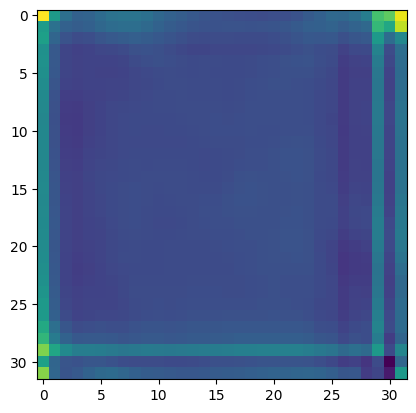

In [ ]:
plt.imshow(y[0,:,:,0])

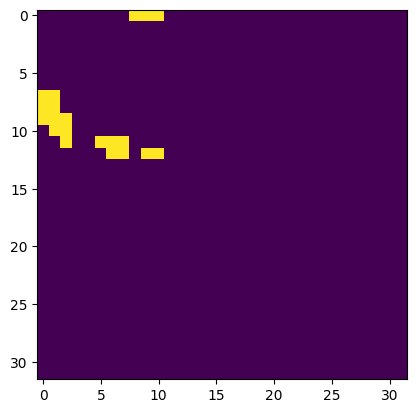

In [ ]:
plt.imshow(Y_test[2,:,:])